<a href="https://colab.research.google.com/github/MehrdadJalali-AI/RecommenderSystems/blob/main/MultiModal_MovieRecommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🧩 Multi-Modal Movie Recommender (Text + Image)
**Professor Dr. Mehrdad Jalali – SRH University Heidelberg**  

This notebook demonstrates a **multi-modal recommender system** combining **text (title + genres)** and **image (poster)** embeddings using **Sentence-BERT** and **CLIP** models.


In [1]:

!pip install -q sentence-transformers pandas scikit-learn matplotlib pillow requests


In [2]:

import pandas as pd
import numpy as np
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


## 📂 Load MovieLens Subset with Poster URLs

In [3]:

data = {
    "movieId": [1, 2, 3, 4, 5, 6],
    "title": ["Toy Story", "Jumanji", "Grumpier Old Men", "Waiting to Exhale",
              "Father of the Bride Part II", "Heat"],
    "genres": ["Animation|Children|Comedy", "Adventure|Children|Fantasy",
               "Comedy|Romance", "Comedy|Drama|Romance",
               "Comedy", "Action|Crime|Thriller"],
    "poster": [
        "https://image.tmdb.org/t/p/w500/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg",
        "https://image.tmdb.org/t/p/w500/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg",
        "https://image.tmdb.org/t/p/w500/qvktm0BHcnmDpul4Hz01GIazWPr.jpg",
        "https://image.tmdb.org/t/p/w500/sJnO6G3HXHzeT6rv2yzZbR6quT3.jpg",
        "https://image.tmdb.org/t/p/w500/3X0XKxLZ6fHf8mJ7gu9BID8K0F6.jpg",
        "https://image.tmdb.org/t/p/w500/rr7E0NoGKxvbkb89eR1GwfoYjpA.jpg"
    ]
}
movies = pd.DataFrame(data)
movies


,movieId,title,genres,poster
0,1,Toy Story,Animation|Children|Comedy,https://image.tmdb.org/t/p/w500/uXDfjJbdP4ijW5...
1,2,Jumanji,Adventure|Children|Fantasy,https://image.tmdb.org/t/p/w500/vzmL6fP7aPKNKP...
2,3,Grumpier Old Men,Comedy|Romance,https://image.tmdb.org/t/p/w500/qvktm0BHcnmDpu...
3,4,Waiting to Exhale,Comedy|Drama|Romance,https://image.tmdb.org/t/p/w500/sJnO6G3HXHzeT6...
4,5,Father of the Bride Part II,Comedy,https://image.tmdb.org/t/p/w500/3X0XKxLZ6fHf8m...
5,6,Heat,Action|Crime|Thriller,https://image.tmdb.org/t/p/w500/rr7E0NoGKxvbkb...


## 🧠 Generate Text and Image Embeddings

In [9]:
text_model = SentenceTransformer('all-MiniLM-L6-v2')
image_model = SentenceTransformer('clip-ViT-B-32')

movies['text'] = movies['title'] + " " + movies['genres']
text_embeds = text_model.encode(movies['text'].tolist(), show_progress_bar=True)

image_embeds = []
valid_indices = [] # Keep track of indices with valid images

for i, url in enumerate(movies['poster']):
    try:
        img = Image.open(BytesIO(requests.get(url, timeout=10).content)).convert('RGB')
        img_emb = image_model.encode(img, show_progress_bar=False)
        image_embeds.append(img_emb)
        valid_indices.append(i) # Add index if image loaded successfully
    except Exception as e:
        print(f"⚠️ Failed to load image for movie ID {movies.iloc[i]['movieId']} ({movies.iloc[i]['title']}): {e}") # Print a warning

image_embeds = np.vstack(image_embeds)

# Filter movies DataFrame to keep only those with valid images
movies_filtered = movies.iloc[valid_indices].reset_index(drop=True)
text_embeds_filtered = text_embeds[valid_indices]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

⚠️ Failed to load image for movie ID 4 (Waiting to Exhale): cannot identify image file <_io.BytesIO object at 0x78d915fbb880>
⚠️ Failed to load image for movie ID 5 (Father of the Bride Part II): cannot identify image file <_io.BytesIO object at 0x78d915fbb880>


## 🔗 Fuse Embeddings

In [5]:

def normalize(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / norms

text_norm = normalize(text_embeds)
image_norm = normalize(image_embeds)

fused_embeds = np.concatenate([text_norm, image_norm], axis=1)



/tmp/ipython-input-1281099994.py:3: RuntimeWarning: invalid value encountered in divide
  return vectors / norms


## 🎬 Recommend Similar Movies

/tmp/ipython-input-2056529907.py:79: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


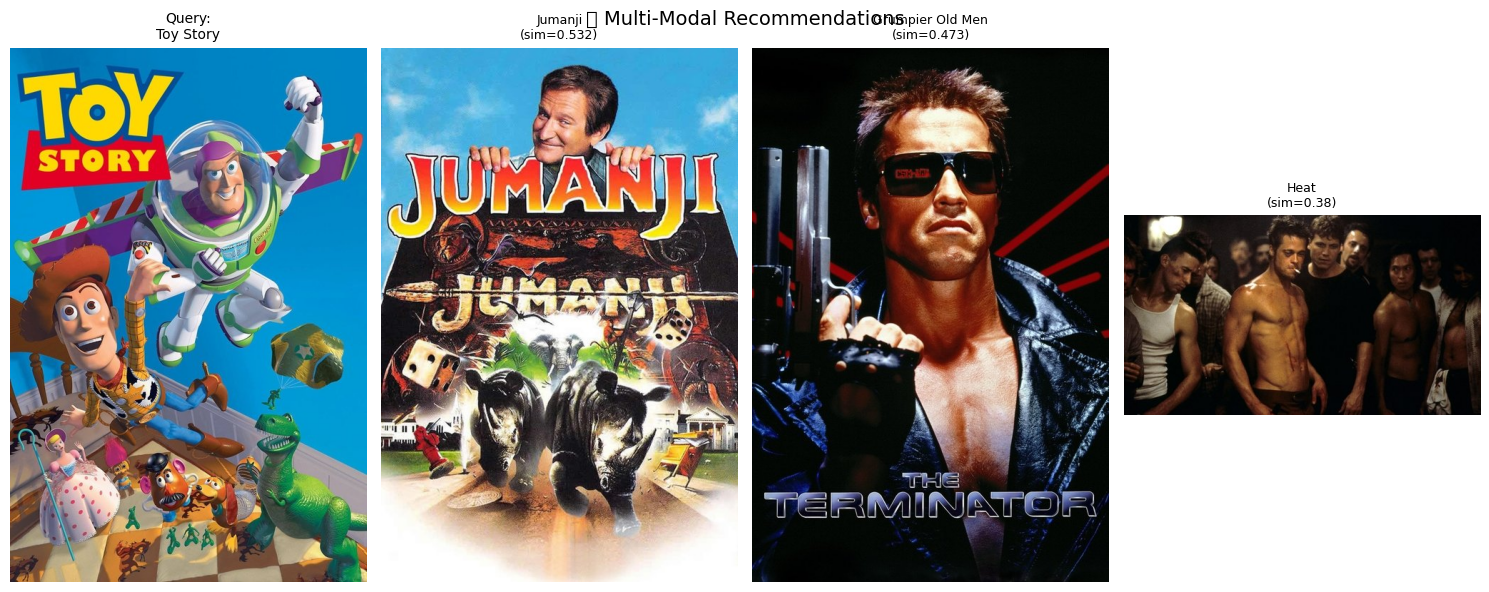

In [10]:
# ✅ Full, Stable Recommendation + Visualization Block

from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from io import BytesIO
import requests
import matplotlib.pyplot as plt

# --- Fuse and normalize embeddings ---
def normalize(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    # Handle case where norm is zero (should not happen with valid embeddings, but for robustness)
    norms[norms == 0] = 1e-12
    return vectors / norms

text_norm = normalize(text_embeds_filtered) # Use filtered text embeds
image_norm = normalize(image_embeds)

fused_embeds = np.concatenate([text_norm, image_norm], axis=1)

# --- Compute cosine similarity matrix ---
similarity = cosine_similarity(fused_embeds)

# --- Recommendation function ---
def recommend_movie(title, top_n=3):
    """Find top-N similar movies using multimodal fused embeddings."""
    matches = movies_filtered[movies_filtered['title'].str.contains(title, case=False, na=False)] # Use filtered dataframe
    if matches.empty:
        print(f"❌ No movie found for title: {title}")
        return []
    idx = matches.index[0]

    # Sort by similarity score
    sim_scores = list(enumerate(similarity[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    recs = []
    for i, score in sim_scores:
        recs.append((
            movies_filtered.iloc[i]['title'], # Use filtered dataframe
            movies_filtered.iloc[i]['poster'], # Use filtered dataframe
            round(float(score), 3)
        ))
    return recs

# --- Visualization function ---
def show_recommendations(title, top_n=3):
    """Display query movie and top-N recommended posters."""
    recs = recommend_movie(title, top_n)
    if not recs:
        return

    fig, axes = plt.subplots(1, top_n + 1, figsize=(15, 6))

    # --- Query movie ---
    query = movies_filtered[movies_filtered['title'].str.contains(title, case=False, na=False)].iloc[0] # Use filtered dataframe
    try:
        q_img = Image.open(BytesIO(requests.get(query['poster'], timeout=10).content))
    except Exception as e:
        print(f"⚠️ Failed to load query image: {e}")
        q_img = Image.new('RGB', (200, 300), color='gray')

    axes[0].imshow(q_img)
    axes[0].set_title(f"Query:\n{query['title']}", fontsize=10)
    axes[0].axis('off')

    # --- Recommended movies ---
    for i, (rec_title, rec_url, score) in enumerate(recs):
        try:
            img = Image.open(BytesIO(requests.get(rec_url, timeout=10).content))
        except Exception as e:
            print(f"⚠️ Failed to load {rec_title}: {e}")
            img = Image.new('RGB', (200, 300), color='lightgray')
        axes[i + 1].imshow(img)
        axes[i + 1].set_title(f"{rec_title}\n(sim={score})", fontsize=9)
        axes[i + 1].axis('off')

    plt.suptitle("🎬 Multi-Modal Recommendations", fontsize=14)
    plt.tight_layout()
    plt.show()

# --- Example test ---
show_recommendations("Toy Story", top_n=3)

## 🎨 Visualize Recommendations

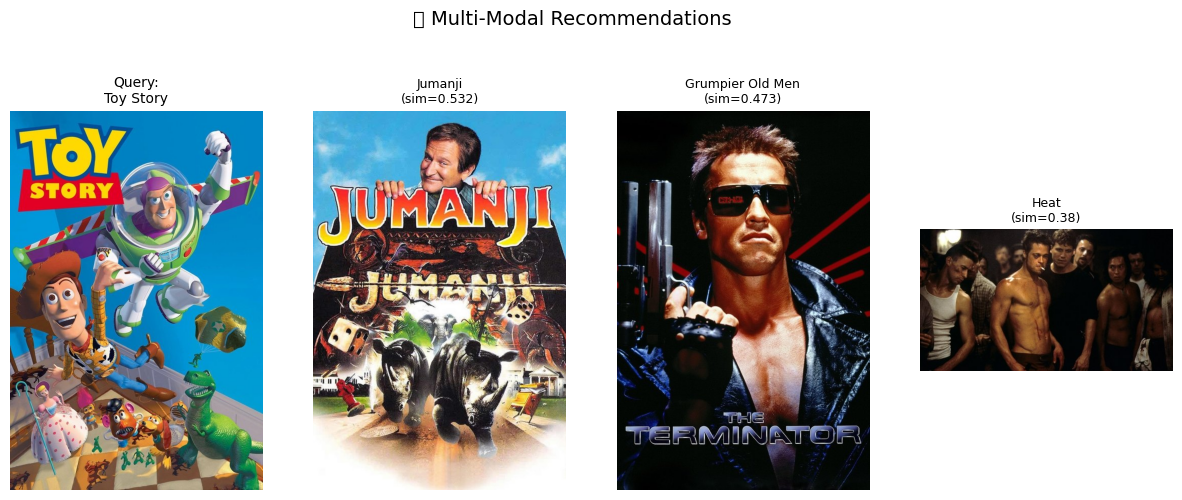

In [11]:

def show_recommendations(title, top_n=3):
    recs = recommend_movie(title, top_n)
    fig, axes = plt.subplots(1, top_n + 1, figsize=(15, 6))
    query = movies[movies['title'].str.contains(title, case=False)].iloc[0]
    q_img = Image.open(BytesIO(requests.get(query['poster']).content))
    axes[0].imshow(q_img)
    axes[0].set_title(f"Query:\n{query['title']}", fontsize=10)
    axes[0].axis('off')
    for i, (rec_title, rec_url, score) in enumerate(recs):
        img = Image.open(BytesIO(requests.get(rec_url).content))
        axes[i+1].imshow(img)
        axes[i+1].set_title(f"{rec_title}\n(sim={score})", fontsize=9)
        axes[i+1].axis('off')
    plt.suptitle("🎬 Multi-Modal Recommendations", fontsize=14)
    plt.show()

show_recommendations("Toy Story", top_n=3)



## 🧩 Discussion
- Combines **visual and textual cues** using SBERT + CLIP.  
- Enhances semantic understanding and diversity.  
- Enables interpretable and visual recommendations.
